In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pyarrow.parquet as pq

In [2]:
file_paths = [
    "data/QCDToGGQQ_IMGjet_RH1all_jet0_run0_n36272_LR.parquet",
    "data/QCDToGGQQ_IMGjet_RH1all_jet0_run1_n47540_LR.parquet",
    "data/QCDToGGQQ_IMGjet_RH1all_jet0_run2_n55494_LR.parquet"
]

## Dataset Exploration

In [3]:
df_list = []
for fp in file_paths:
    pf = pq.ParquetFile(fp)
    batch = next(pf.iter_batches(batch_size=100))
    df_list.append(batch.to_pandas())

df = pd.concat(df_list, ignore_index=True)

In [4]:
print("Dataset Columns:", df.columns)
print("Number of Samples:", len(df))

Dataset Columns: Index(['X_jets_LR', 'X_jets', 'pt', 'm0', 'y'], dtype='object')
Number of Samples: 300


In [5]:
df.describe()

,pt,m0,y
count,300.000000,300.000000,300.000000
mean,116.913870,20.956278,0.480000
std,25.567939,5.966501,0.500435
min,75.781281,7.815182,0.000000
25%,98.774593,16.781054,0.000000
50%,110.637585,20.031707,0.000000
75%,129.321957,23.521461,1.000000
max,238.406982,46.464977,1.000000


In [6]:
df.head()

,X_jets_LR,X_jets,pt,m0,y
0,"[[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0...","[[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0...",112.411095,21.098248,0.0
1,"[[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0...","[[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0...",95.220406,14.030600,1.0
2,"[[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0...","[[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0...",97.007317,17.728968,1.0
3,"[[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0...","[[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0...",82.490311,14.702741,0.0
4,"[[[0.0, 0.0, 0.0, 0.0, 0.08212081342935562, 0....","[[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.328483...",102.539238,19.456257,0.0


In [7]:
print(df["X_jets"][0].shape)

print(df["X_jets_LR"][0][0].shape)
print(df["X_jets_LR"][0][1].shape)
print(df["X_jets_LR"][0][2].shape)

print(df["X_jets"][0][0].shape)
print(df["X_jets"][0][1].shape)
print(df["X_jets"][0][2].shape)

(3,)
(64,)
(64,)
(64,)
(125,)
(125,)
(125,)


In [8]:
print("Example HR image shape:", df["X_jets"][0].shape)
print("Example LR image shape:", df["X_jets_LR"][0].shape)

Example HR image shape: (3,)
Example LR image shape: (3,)


In [9]:
print("Shape of X_jets[0]:", df["X_jets"][0].shape)
print("Shape of X_jets[0][0]:", df["X_jets"][0][0].shape)

Shape of X_jets[0]: (3,)
Shape of X_jets[0][0]: (125,)


In [10]:
df['X_jets'] = df['X_jets'].apply(lambda x: np.stack([np.stack(ch).astype(np.float32) for ch in x]))
df['X_jets_LR'] = df['X_jets_LR'].apply(lambda x: np.stack([np.stack(ch).astype(np.float32) for ch in x]))

In [11]:
print("High-res image shape:", df['X_jets'].iloc[0].shape)
print("Low-res image shape:", df['X_jets_LR'].iloc[0].shape)

High-res image shape: (3, 125, 125)
Low-res image shape: (3, 64, 64)


## Visualize Dataset

In [12]:
def normalize_image(img):
    """
    Normalize image data to the range [0, 1].
    """
    img = np.array(img, dtype=np.float32)
    min_val = img.min()
    max_val = img.max()
    if max_val - min_val > 0:
        return (img - min_val) / (max_val - min_val)
    else:
        return img

def prepare_image(img):
    """
    Transpose from channel-first (3, H, W) to channel-last (H, W, 3)
    and normalize the image data to [0,1] for proper display.
    """
    img = np.transpose(img, (1, 2, 0))
    return normalize_image(img)

def plot_class_images(df_class, class_label):
    """
    For each sample in the DataFrame, plot the high-res and low-res images side by side.
    """
    n_samples = len(df_class)
    fig, axes = plt.subplots(n_samples, 2, figsize=(8, 4 * n_samples))
    
    if n_samples == 1:
        axes = np.expand_dims(axes, axis=0)
    
    for i, (_, row) in enumerate(df_class.iterrows()):
        hr_img = prepare_image(row['X_jets'])
        lr_img = prepare_image(row['X_jets_LR'])
        
        axes[i, 0].imshow(hr_img)
        axes[i, 0].set_title(f'Class {class_label} High-res')
        axes[i, 0].axis('off')
        
        axes[i, 1].imshow(lr_img)
        axes[i, 1].set_title(f'Class {class_label} Low-res')
        axes[i, 1].axis('off')
    
    plt.tight_layout()
    plt.show()

In [13]:
num_samples = 5
class0 = df[df['y'] == 0].sample(num_samples, random_state=69)
class1 = df[df['y'] == 1].sample(num_samples, random_state=69)

Class 0 Samples:


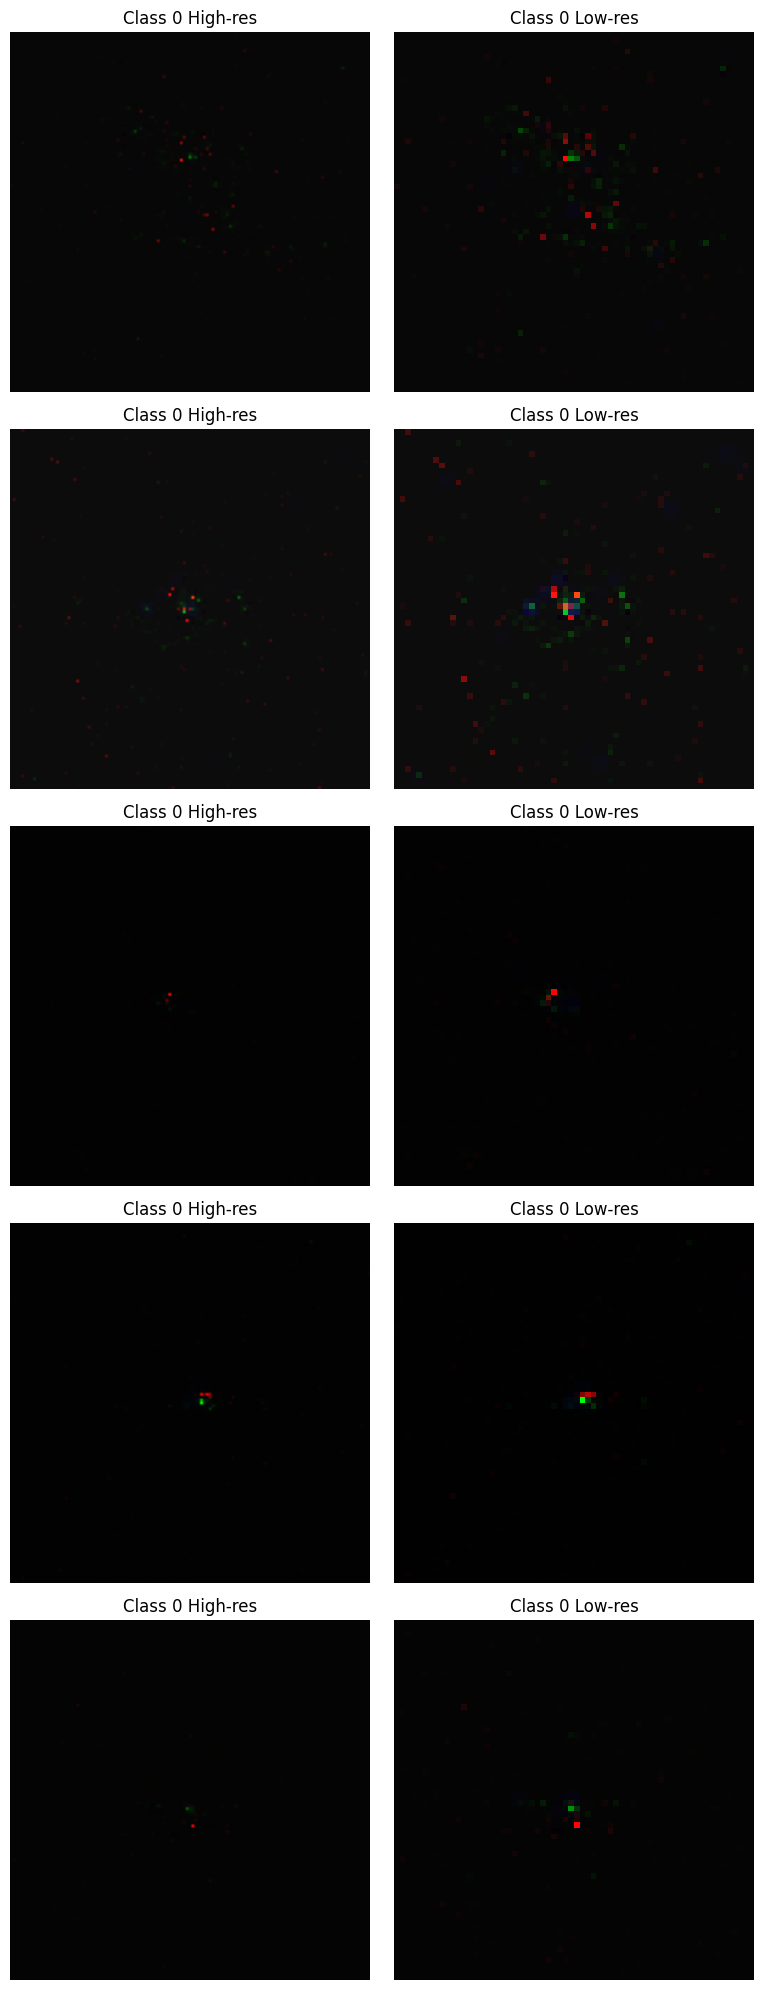

In [14]:
print("Class 0 Samples:")
plot_class_images(class0, class_label=0)

Class 1 Samples:


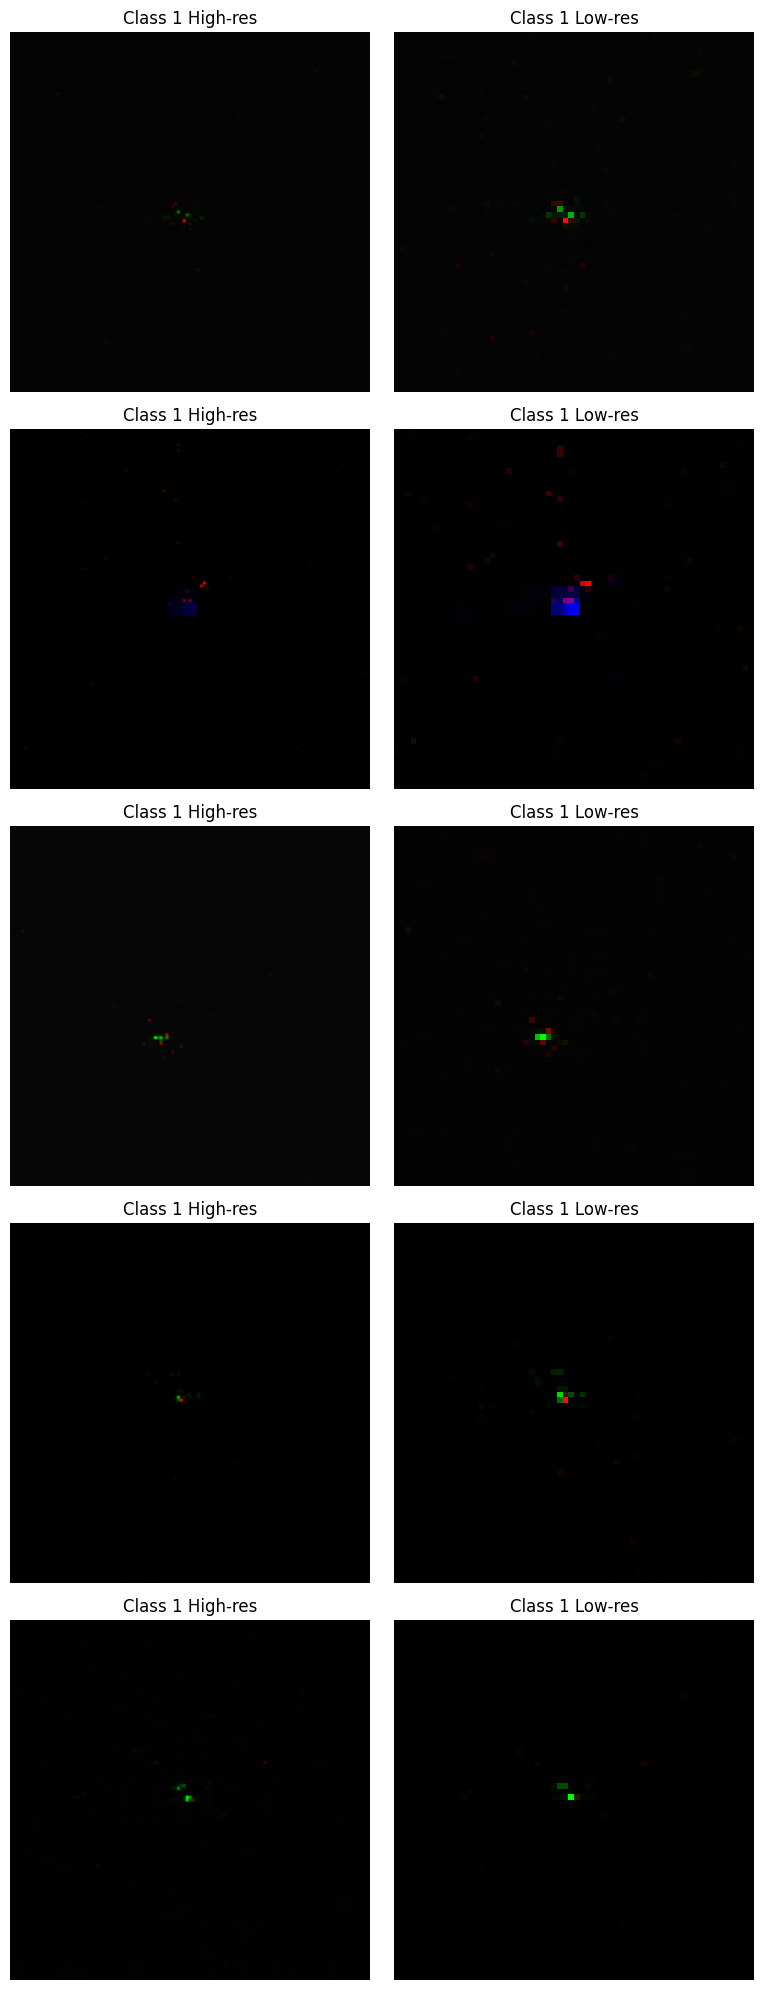

In [15]:
print("Class 1 Samples:")
plot_class_images(class1, class_label=1)

## Validation result Visualization

In [16]:
import matplotlib.image as mpimg
import os
import glob

In [17]:
eval_dir = "images/training"
val_images = sorted(glob.glob(os.path.join(eval_dir, "epoch_*_val.png")))

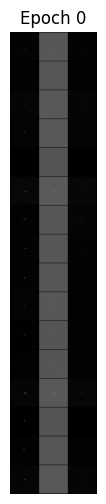

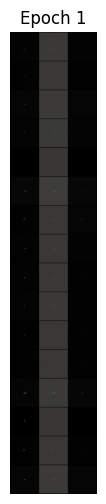

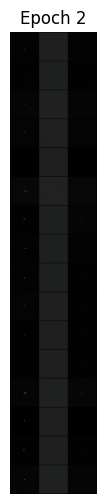

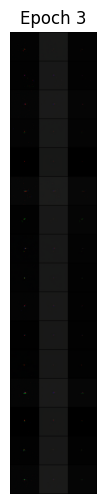

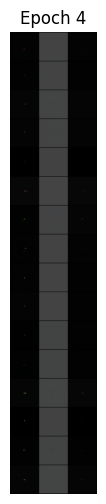

In [18]:
if not val_images:
    print("No evaluation images found in the directory.")
else:
    for img_path in val_images:
        epoch_num = os.path.basename(img_path).split('_')[1]
        image = mpimg.imread(img_path)

        plt.figure(figsize=(6, 6))
        plt.imshow(image)
        plt.title(f"Epoch {epoch_num}")
        plt.axis('off')
        plt.show()

## Test Trained model

In [19]:
import models
import torch
import torch.nn.functional as F
from models import GeneratorRRDB

In [20]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


In [21]:
hr_height, hr_width = 125, 125

In [22]:
generator = GeneratorRRDB(channels=3, filters=64, num_res_blocks=23).to(device)
generator.load_state_dict(torch.load("saved_models/generator_best.pth", map_location=device))
generator.eval()

GeneratorRRDB(
  (initial): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (res_blocks): Sequential(
    (0): ResidualInResidualDenseBlock(
      (dense_blocks): Sequential(
        (0): DenseResidualBlock(
          (b1): Sequential(
            (0): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
            (1): LeakyReLU(negative_slope=0.01)
          )
          (b2): Sequential(
            (0): Conv2d(128, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
            (1): LeakyReLU(negative_slope=0.01)
          )
          (b3): Sequential(
            (0): Conv2d(192, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
            (1): LeakyReLU(negative_slope=0.01)
          )
          (b4): Sequential(
            (0): Conv2d(256, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
            (1): LeakyReLU(negative_slope=0.01)
          )
          (b5): Sequential(
            (0): Conv2d(320, 64, kernel_size=(3, 3), strid

In [23]:
def exact_resize(x):
    return F.interpolate(x, size=(hr_height, hr_width), mode='bicubic', align_corners=True)

In [24]:
num_samples = 10
samples = df.sample(num_samples, random_state=101)

In [ ]:
lr_images = []
hr_images = []
for idx, row in samples.iterrows():
    lr_img = torch.from_numpy(row['X_jets_LR']).unsqueeze(0)  # shape: (1, 3, 64, 64)
    hr_img = torch.from_numpy(row['X_jets']).unsqueeze(0)       # shape: (1, 3, 125, 125)
    
    # Normalize images to [-1, 1]
    lr_img = (lr_img - lr_img.min()) / (lr_img.max() - lr_img.min()) * 2 - 1
    hr_img = (hr_img - hr_img.min()) / (hr_img.max() - hr_img.min()) * 2 - 1
    
    lr_images.append(lr_img)
    hr_images.append(hr_img)

In [26]:
lr_batch = torch.cat(lr_images, dim=0).to(device)
hr_batch = torch.cat(hr_images, dim=0).to(device)

with torch.no_grad():
    gen_hr = generator(lr_batch)
    gen_hr = exact_resize(gen_hr)

In [ ]:
def tensor_to_image(tensor):
    """
    Convert a tensor image in range [-1,1] to a numpy image in [0,1].
    """
    tensor = tensor.cpu().detach()
    tensor = (tensor + 1) / 2
    tensor = torch.clamp(tensor, 0, 1)
    return tensor.numpy()

In [28]:
lr_images_np = [tensor_to_image(img) for img in lr_batch]
gen_hr_images_np = [tensor_to_image(img) for img in gen_hr]
hr_images_np = [tensor_to_image(img) for img in hr_batch]

In [29]:
def plot_comparison(lr_img, gen_hr_img, true_hr_img, title_suffix=""):
    """
    Plot the low-resolution image, the generated high-resolution image, and the ground truth high-resolution image.
    """
    fig, axes = plt.subplots(1, 3, figsize=(15, 5))
    axes[0].imshow(prepare_image(lr_img))
    axes[0].set_title("Low-res Input " + title_suffix)
    axes[0].axis('off')
    
    axes[1].imshow(prepare_image(gen_hr_img))
    axes[1].set_title("Generated HR " + title_suffix)
    axes[1].axis('off')
    
    axes[2].imshow(prepare_image(true_hr_img))
    axes[2].set_title("Ground Truth HR " + title_suffix)
    axes[2].axis('off')
    
    plt.tight_layout()
    plt.show()

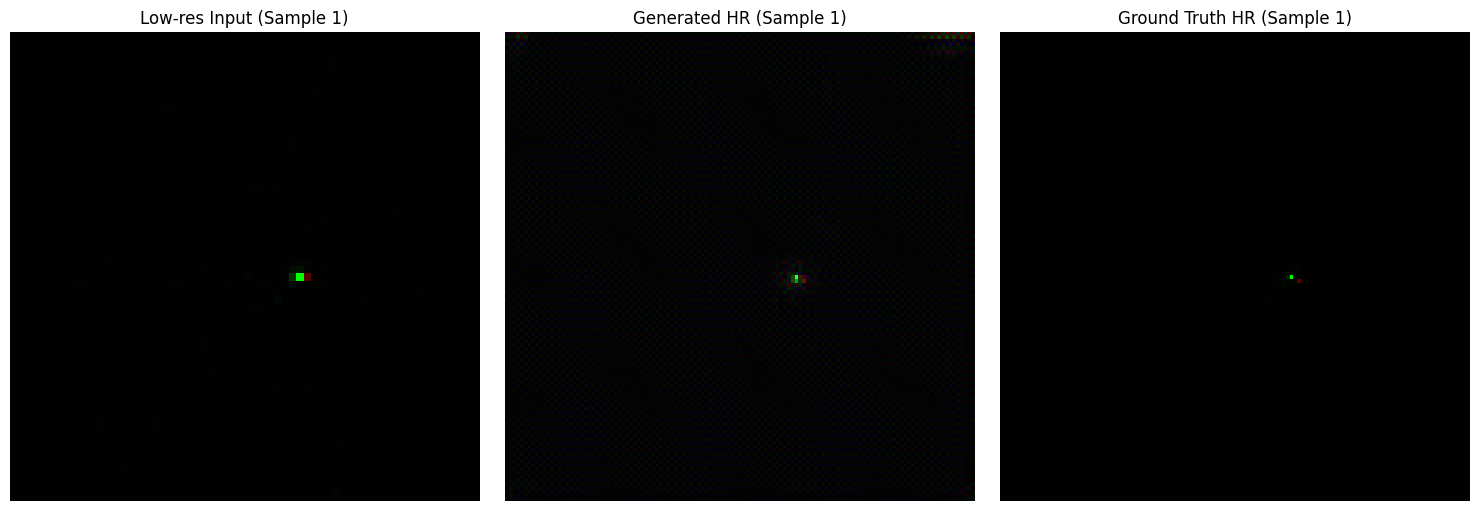

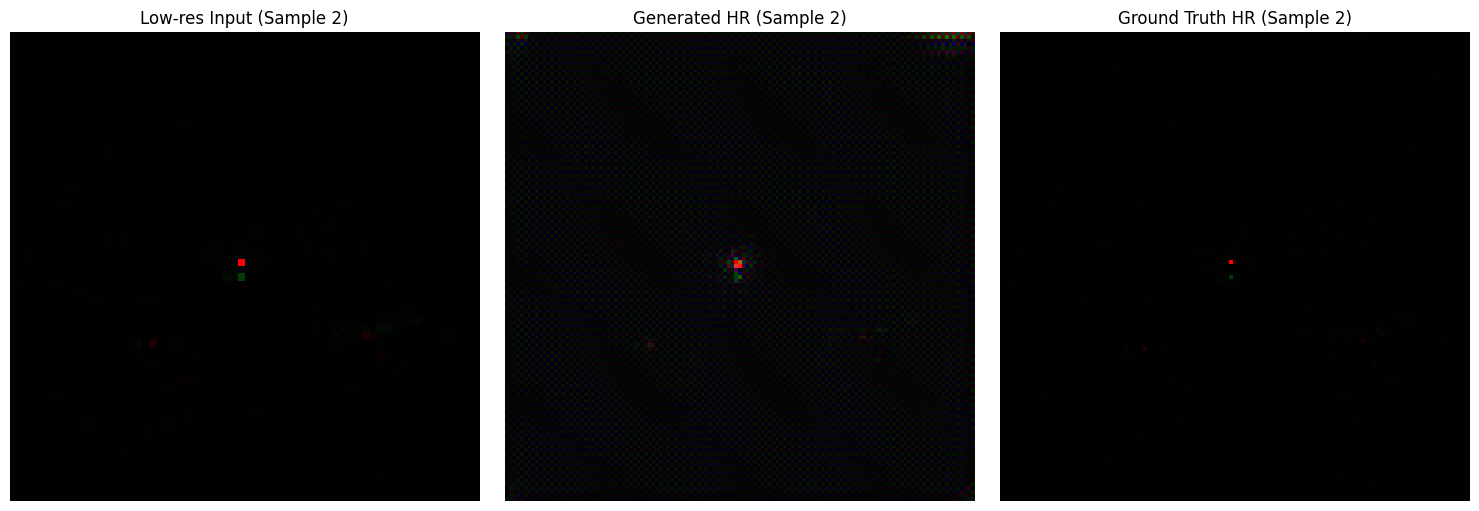

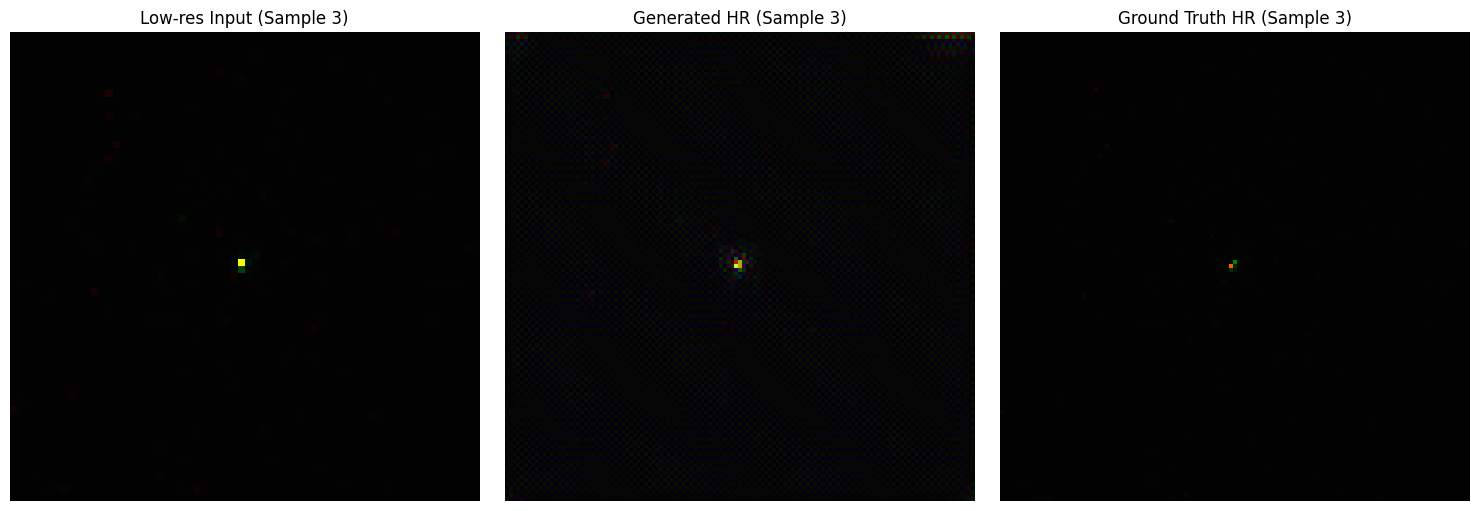

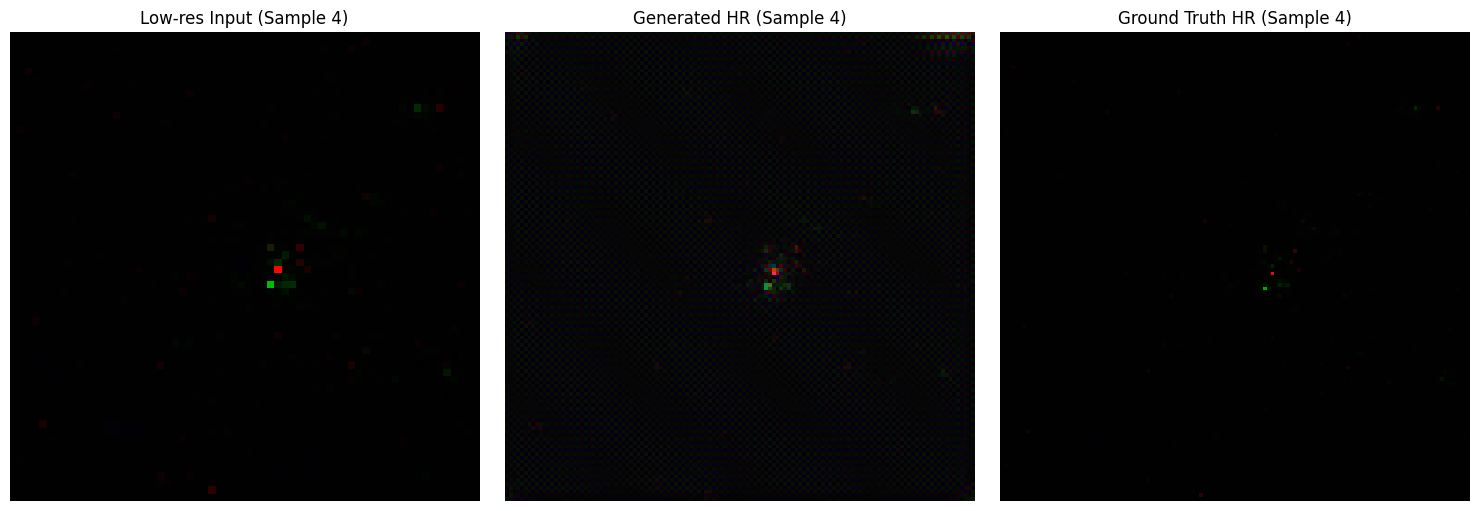

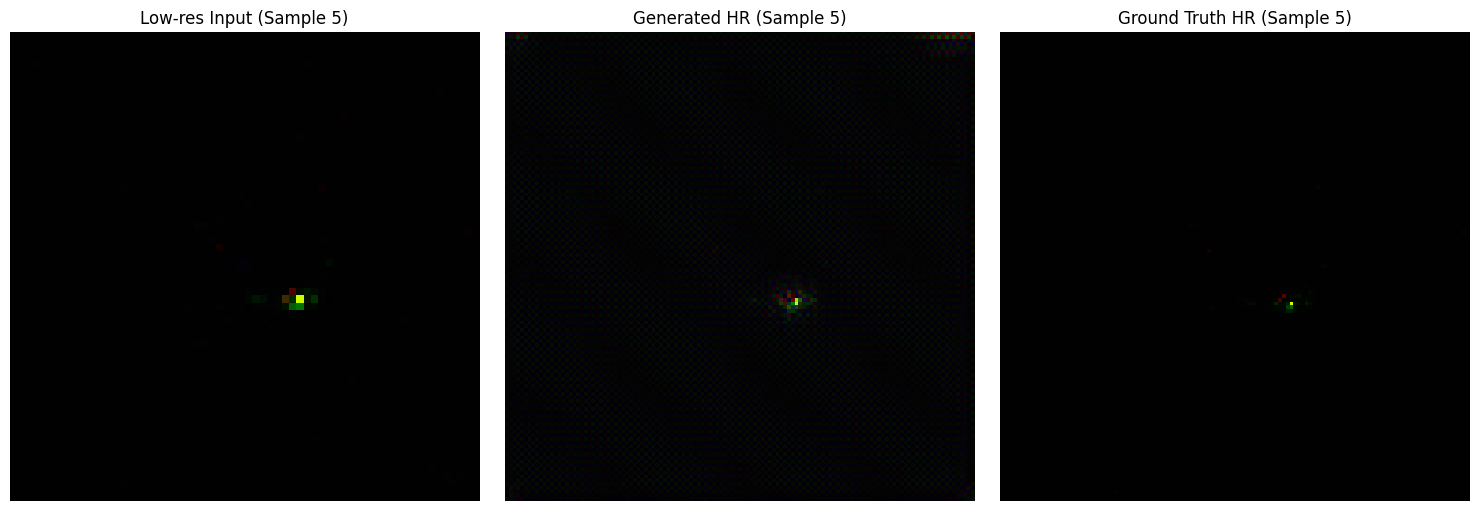

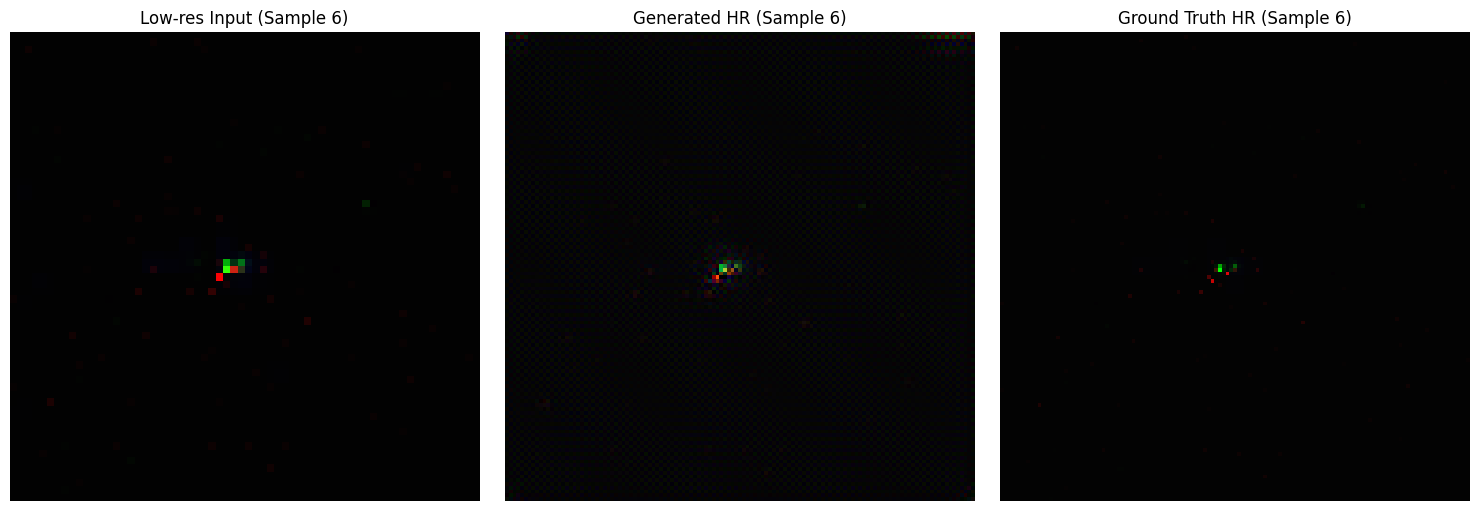

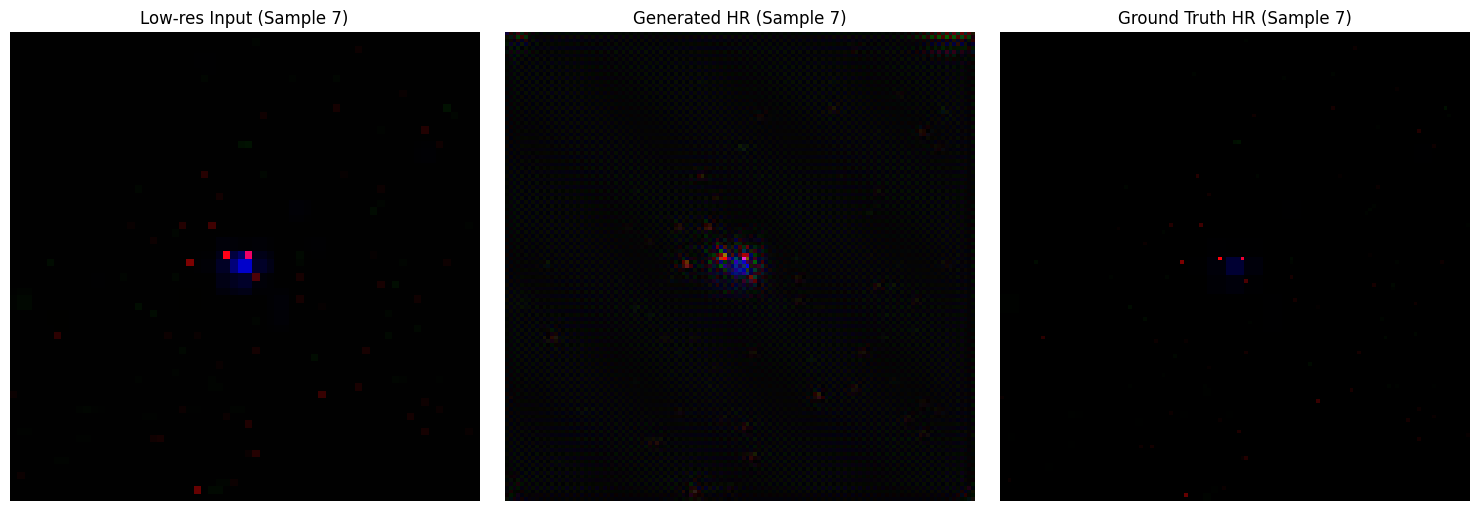

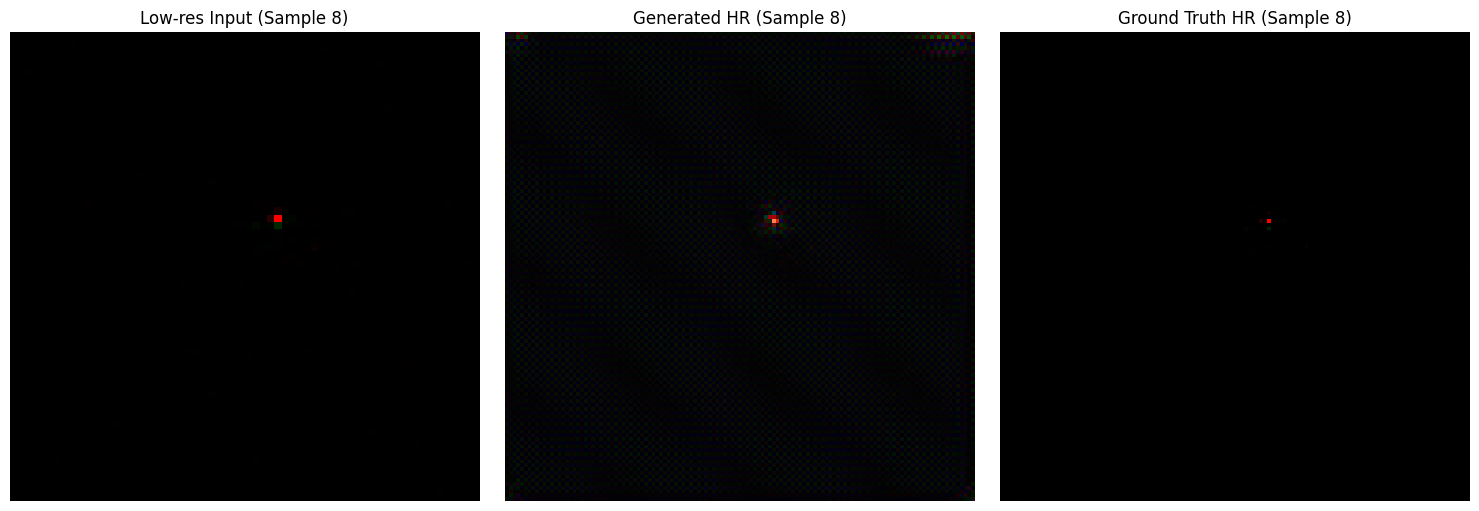

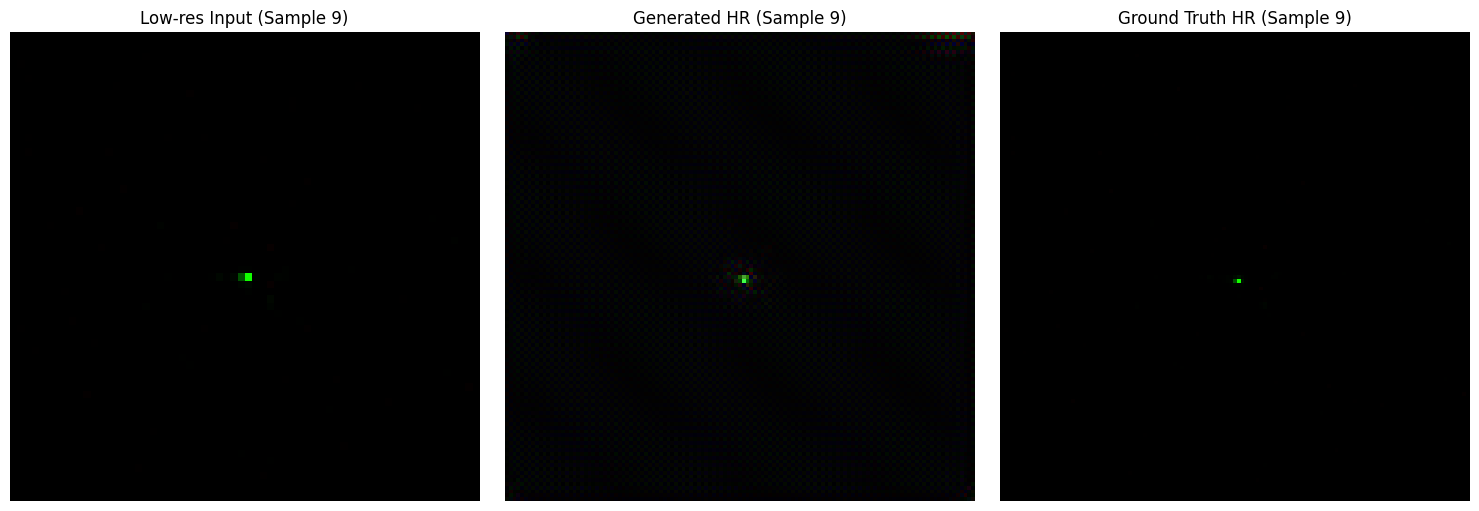

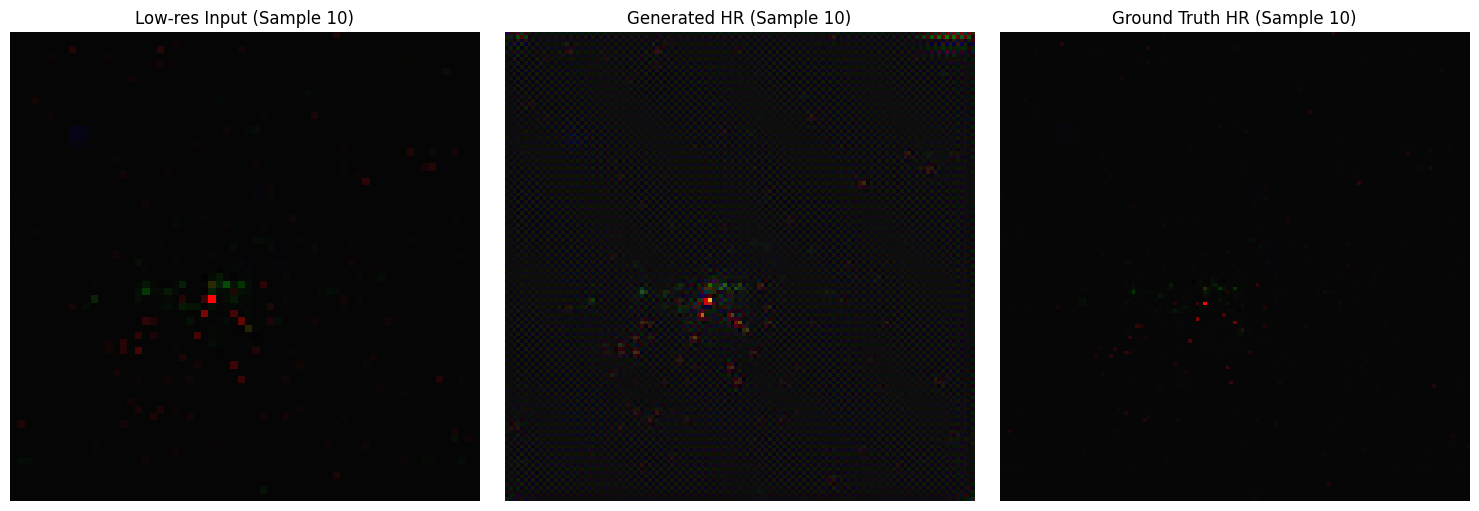

In [30]:
for i in range(num_samples):
    plot_comparison(lr_images_np[i], gen_hr_images_np[i], hr_images_np[i], title_suffix=f"(Sample {i+1})")